In [6]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from datetime import date, timedelta
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import spotpy
from scipy import stats

import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy
import colorcet as cc
from cmcrameri import cm
import matplotlib as mpl
import proplot as pplt
import xarray
#warning
import warnings
warnings.filterwarnings('ignore')

os.chdir('D:/Xanthos-Repo/Data')

In [7]:
#############################################################
basinName = pd.read_csv('BasinNames235.txt')
basin_id = pd.read_csv('basin.csv')
GRDC_xanthosCoordIndx = pd.read_csv('GRDC_stations_list.csv')
basins94 = np.array(GRDC_xanthosCoordIndx['basins']).astype(np.int64)
xanthosid = np.array(GRDC_xanthosCoordIndx['xanthosID_new_adj']).astype(np.int64)
basinName_94 = [basinName['Basin_Name'][basins94[ii] - 1] for ii in range(GRDC_xanthosCoordIndx.shape[0])]

## Release

In [8]:
reservoirs_halfDegree = xarray.open_dataset('Xanthos_reservoirs_halfDegree_global.nc')
ppose = reservoirs_halfDegree.Main_Use.values
Capacity = reservoirs_halfDegree.Capacity.values
Basin = reservoirs_halfDegree.Basin.values
Lon = reservoirs_halfDegree.Lon.values
Lat = reservoirs_halfDegree.Lat.values
Xanthos_Catch_SKM = reservoirs_halfDegree.Xanthos_Catch_SKM.values

# directory for reservoir release data
file_dir_hp = 'D:\\XanthosDev\\Results-02-27-2022\\Simulated\\SimulatedFinal-HP\\reservoirRelease\\'
file_dir_fc = 'D:\\XanthosDev\\Results-02-27-2022\\Simulated\\SimulatedFinal-FC\\reservoirRelease\\'

for jj in range(len(basins94)):
    # get grids u/s of GRDC site
    basin_num = basins94[jj]
    dir_usgrid = 'D:/XanthosDev/Figures/Basins_Result/UScells/contributing_grids_all'
    datad = (np.array(pd.read_csv(dir_usgrid + str(basin_num) + '.csv',header=None)) - 1).astype(np.int64)
    basin_idx = np.squeeze(datad) 
    basin_idx = basin_idx[basin_idx>0]
    # reservoirs properties for grids u/s of GRDC sites
    ppose_allgrid = ppose[basin_idx]
    capac_allgrid = Capacity[basin_idx]
    Lon_allgrids = Lon[basin_idx]
    Lat_allgrdis = Lat[basin_idx]
    da_allgrids = Xanthos_Catch_SKM[basin_idx]
    # reservoir grids
    ppose_basin = ppose_allgrid[(ppose_allgrid>0)]
    capac_basin = capac_allgrid[(ppose_allgrid>0)]
    Lon_basin = Lon_allgrids[(ppose_allgrid>0)]
    Lat_basin = Lat_allgrdis[(ppose_allgrid>0)]

    # get HP reservoirs grid us/s for GRDC
    ppose_HP = ppose_basin[ppose_basin==1]
    capac_HP = capac_basin[capac_basin==1]
    Lon_HP = Lon_basin[ppose_basin==1]
    Lat_HP = Lat_basin[ppose_basin==1]
    indx_basin = np.where((ppose_basin==1))[0]

    ## simulated
    data_basin_hp = np.load(file_dir_hp + 'ReservoirsRelease_' + str(basin_num) + '.npy') 
    data_basin_fc = np.load(file_dir_fc + 'ReservoirsRelease_' + str(basin_num) + '.npy')   

    # compute KGE between the two
    nrmse_hpfc = np.zeros([indx_basin.shape[0],])
    r2_hpfc  = np.zeros([indx_basin.shape[0],])
    for ii in range(indx_basin.shape[0]):
        mm = indx_basin[ii]
        # with hydropower
        rsim_hp= data_basin_hp[mm,:]
        # with flood control
        rsim_fc= data_basin_fc[mm,:]
        #plt.show()
        nrmse_hpfc[ii] = spotpy.objectivefunctions.rmse(rsim_fc[0:240], rsim_hp[0:240])/np.mean(rsim_hp[0:240])
        r2_hpfc[ii] = spotpy.objectivefunctions.rsquared(rsim_fc[0:240], rsim_hp[0:240])

    nrmse_hpfc_df_release = pd.DataFrame()
    nrmse_hpfc_df_release['Lon'] = Lon_HP
    nrmse_hpfc_df_release['Lat'] = Lat_HP

    #kge_hpfc[kge_hpfc  < -1] = -1 #for colorbar purpose only
    nrmse_hpfc_df_release['NRMSE'] = nrmse_hpfc
    nrmse_hpfc_df_release['R2'] = r2_hpfc
    if jj==0:
        nrmse_hpfc_all_release = nrmse_hpfc_df_release
    else:
        nrmse_hpfc_all_release = pd.concat([nrmse_hpfc_all_release, nrmse_hpfc_df_release],0)


#### Storage 

In [9]:
# directory for reservoir release data
file_dir_hp = 'D:\\XanthosDev\\Results-02-27-2022\\Simulated\\SimulatedFinal-HPx\\reservoir\\'
file_dir_fc = 'D:\\XanthosDev\\Results-02-27-2022\\Simulated\\SimulatedFinal-FCx\\reservoir\\'
cc=0
for jj in range(len(basins94)):
    # get grids u/s of GRDC site
    basin_num = basins94[jj]
    dir_usgrid = 'D:/XanthosDev/Figures/Basins_Result/UScells/contributing_grids_all'
    datad = (np.array(pd.read_csv(dir_usgrid + str(basin_num) + '.csv',header=None)) - 1).astype(np.int64)
    basin_idx = np.squeeze(datad) 
    basin_idx = basin_idx[basin_idx>0]
    # reservoirs properties for grids u/s of GRDC sites
    ppose_allgrid = ppose[basin_idx]
    capac_allgrid = Capacity[basin_idx]
    Lon_allgrids = Lon[basin_idx]
    Lat_allgrdis = Lat[basin_idx]
    da_allgrids = Xanthos_Catch_SKM[basin_idx]
    # reservoir grids
    ppose_basin = ppose_allgrid[(ppose_allgrid>0)]
    capac_basin = capac_allgrid[(ppose_allgrid>0)]
    Lon_basin = Lon_allgrids[(ppose_allgrid>0)]
    Lat_basin = Lat_allgrdis[(ppose_allgrid>0)]

    # get HP reservoirs grid us/s for GRDC
    ppose_HP = ppose_basin[ppose_basin==1]
    capac_HP = capac_basin[capac_basin==1]
    Lon_HP = Lon_basin[ppose_basin==1]
    Lat_HP = Lat_basin[ppose_basin==1]
    indx_basin = np.where((ppose_basin==1))[0]

    ## simulated
    data_basin_hp = np.load(file_dir_hp + 'SimReservoirs_' + str(basin_num) + '.npy') 
    data_basin_fc = np.load(file_dir_fc + 'SimReservoirs_' + str(basin_num) + '.npy')   
    if np.sum(data_basin_fc)==0:
        cc+=1

    # compute KGE between the two
    nrmse_hpfc = np.zeros([indx_basin.shape[0],])
    r2_hpfc  = np.zeros([indx_basin.shape[0],])
    for ii in range(indx_basin.shape[0]):
        mm = indx_basin[ii]
        # with hydropower
        rsim_hp= data_basin_hp[mm,:]*1e-6
        # with flood control
        rsim_fc= data_basin_fc[mm,:]*1e-6
        #plt.show()
        nrmse_hpfc[ii] = spotpy.objectivefunctions.rmse(rsim_fc[0:240], rsim_hp[0:240])/np.mean(rsim_hp[0:240])
        r2_hpfc[ii] = spotpy.objectivefunctions.rsquared(rsim_fc[0:240], rsim_hp[0:240])

    nrmse_hpfc_df_storage = pd.DataFrame()
    nrmse_hpfc_df_storage['Lon'] = Lon_HP
    nrmse_hpfc_df_storage['Lat'] = Lat_HP

    #nrmse_hpfc[kge_hpfc  <-1] = -1 #for colorbar purpose only
    nrmse_hpfc_df_storage['NRMSE'] = nrmse_hpfc
    nrmse_hpfc_df_storage['R2'] = r2_hpfc
    if jj==0:
        nrmse_hpfc_all_storage = nrmse_hpfc_df_storage
    else:
        nrmse_hpfc_all_storage = pd.concat([nrmse_hpfc_all_storage, nrmse_hpfc_df_storage],0)


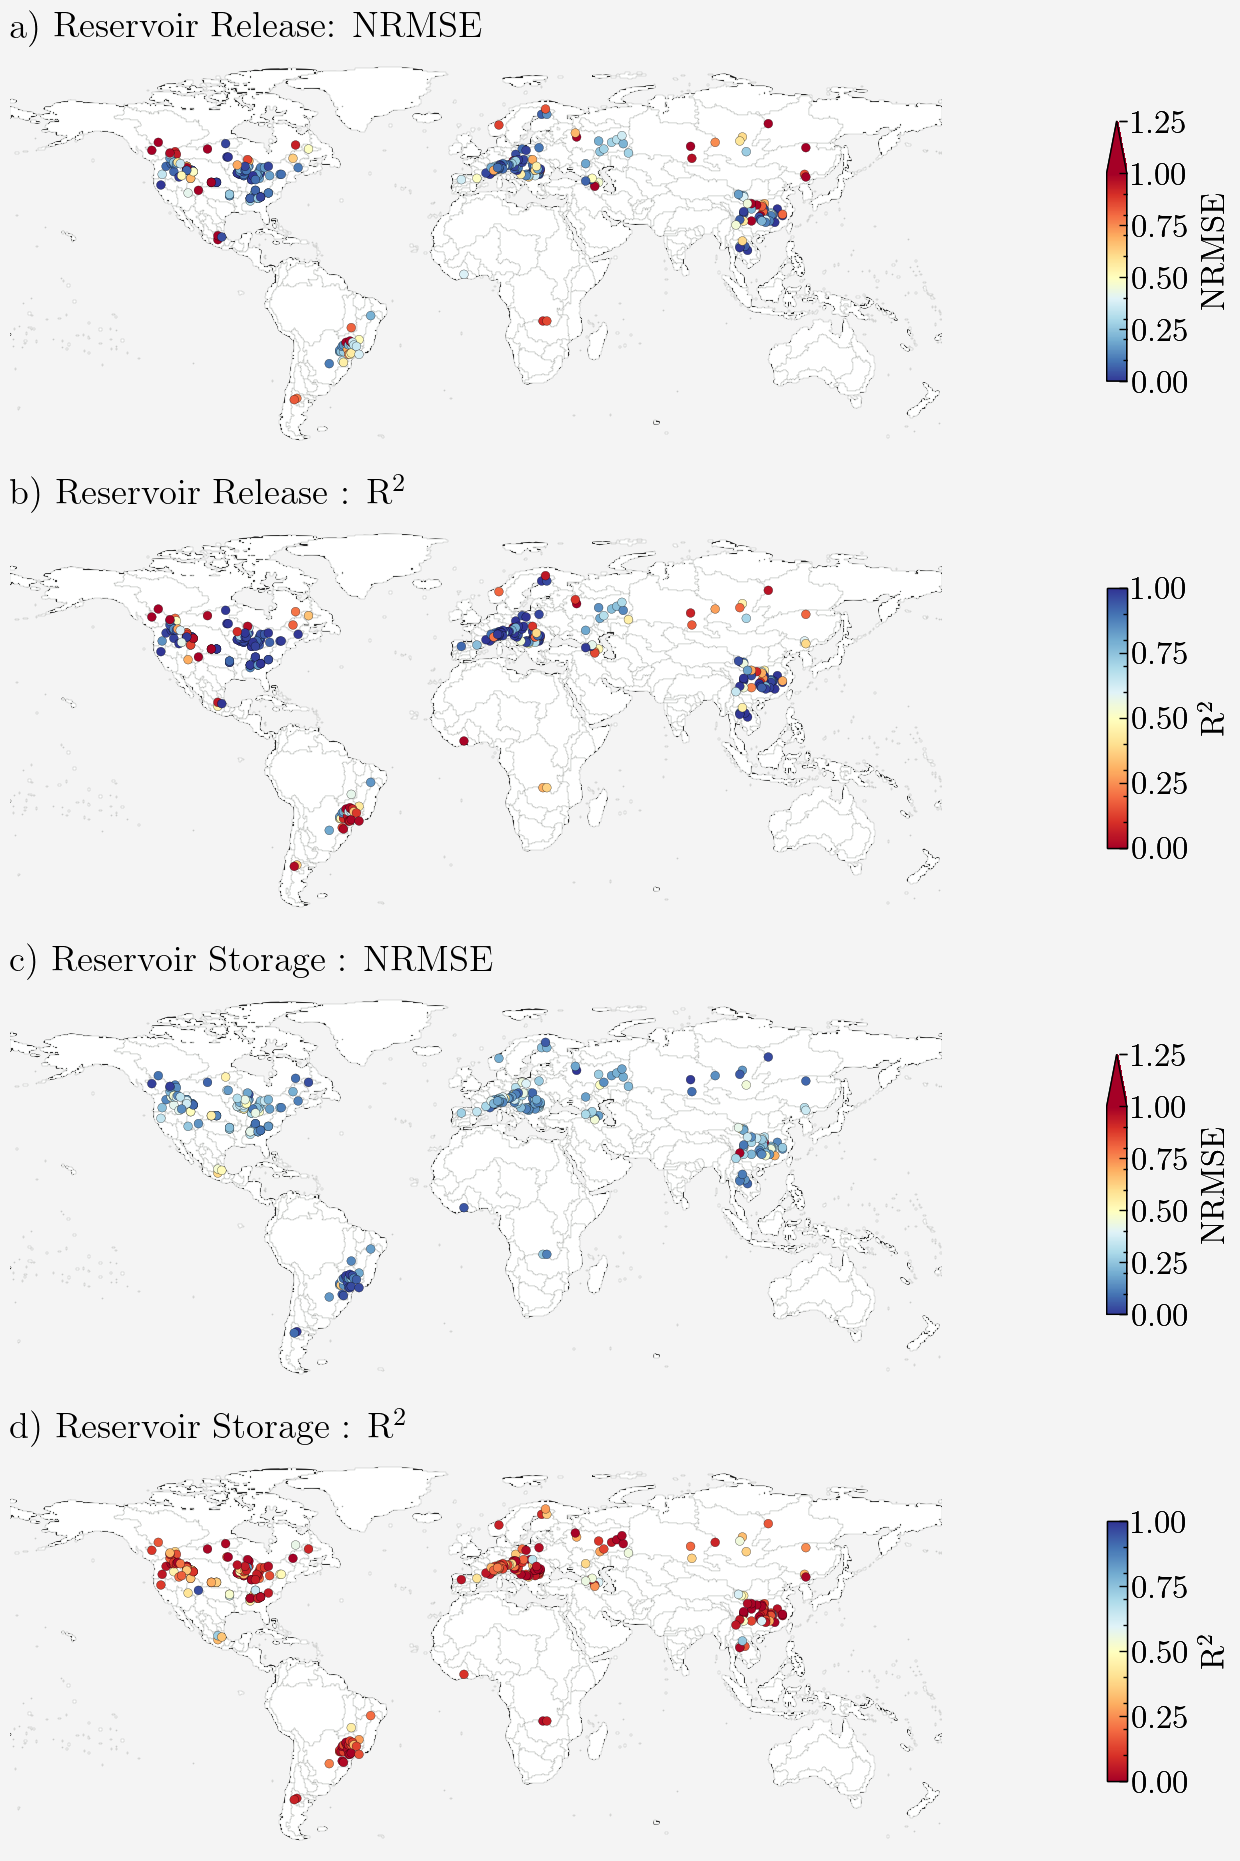

In [14]:
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.autolayout'] = True 
plt.rcParams.update({'font.size': 12}) 

CRS = "EPSG:4326"
## Ploting
SAVE_KWDS = {"bbox_inches": "tight", "dpi": 450, "facecolor": "w"}
BASE_PLOT = {"facecolor": 'none', "edgecolor": 'k', "alpha": 0.9,}


basin_235_xanthos = gpd.read_file('D:\\GCAM-Manuscript\\Figurers\\Data Spatial Map\\basin_235_xanthos\\basin_harmed.shp')
basin_235_xanthos['dx'] = 1


world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
global_shape = gpd.GeoDataFrame(geometry=world.geometry, crs=world.crs)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#world.boundary.plot()
# Release                                                  
kge_hpfc_all_gdf_release = gpd.GeoDataFrame(nrmse_hpfc_all_release, geometry=gpd.points_from_xy(
                                   nrmse_hpfc_all_release.Lon, 
                                   nrmse_hpfc_all_release.Lat))
kge_hpfc_all_gdf_release.crs = "EPSG:4326"
## Storage
kge_hpfc_all_gdf_storage = gpd.GeoDataFrame(nrmse_hpfc_all_storage, geometry=gpd.points_from_xy(
                                   nrmse_hpfc_all_storage.Lon, 
                                   nrmse_hpfc_all_storage.Lat))
kge_hpfc_all_gdf_storage.crs = "EPSG:4326"


fig, axes = pplt.subplots(nrows=4, ncols=1, share=0, space = 2, refheight='2.0', journal='pnas3')
plt.style.use('science')
with plt.style.context(['science', 'high-contrast']):
        ########## KGE
        ax = axes[0]
        world.to_crs(CRS).plot(ax=ax,**BASE_PLOT)  
        basin_235_xanthos.to_crs(CRS).plot(ax=ax, column='dx', cmap=None, legend=False,  facecolor=None, edgecolor='gray',linewidth=0.1)        
        kge_hpfc_all_gdf_release.to_crs(CRS).plot(ax=ax, column='NRMSE', cmap='RdYlBu_r', s=10, legend=True, vmin=0, vmax=1, edgecolor='k',linewidth=0.1,
                                        legend_kwds={'label': "NRMSE", 'shrink':0.65,'width':0.10,
                                                     'extend':'max', 'ticks':0.25, 'minorticks':0.1})                                                                                  
        ax.axis(False)
        ax.xaxis.label.set_visible(False)
        ax.yaxis.label.set_visible(False)
        ax.autoscale(tight=True)  
        ax.set_ylim([-60,90]) 
        ax.format(title='Reservoir Release: NRMSE' , titleloc='l',abcstyle='a)', fontsize=28)

        ax = axes[1]
        world.to_crs(CRS).plot(ax=ax,**BASE_PLOT)  
        basin_235_xanthos.to_crs(CRS).plot(ax=ax, column='dx', cmap=None, legend=False,  facecolor=None, edgecolor='gray',linewidth=0.1)        
        kge_hpfc_all_gdf_release.to_crs(CRS).plot(ax=ax, column='R2', cmap='RdYlBu', s=10, legend=True, vmin=0, vmax=1, edgecolor='k',linewidth=0.1,
                                        legend_kwds={'label': 'R'+r'$^{2}$', 'shrink':0.65,'width':0.10,
                                                      'ticks':0.25, 'minorticks':0.1})                                                                                  
        ax.axis(False)
        ax.xaxis.label.set_visible(False)
        ax.yaxis.label.set_visible(False)
        ax.autoscale(tight=True)  
        ax.set_ylim([-60,90]) 
        ax.format(title='Reservoir Release : R'+r'$^{2}$' , titleloc='l',abcstyle='a)', fontsize=28)

        ########## R2
        ax = axes[2]
        world.to_crs(CRS).plot(ax=ax,**BASE_PLOT)  
        basin_235_xanthos.to_crs(CRS).plot(ax=ax, column='dx', cmap=None, legend=False,  facecolor=None, edgecolor='gray',linewidth=0.1)        
        kge_hpfc_all_gdf_storage.to_crs(CRS).plot(ax=ax, column='NRMSE', cmap='RdYlBu_r', s=10, legend=True, vmin=0, vmax=1, edgecolor='k',linewidth=0.1,
                                        legend_kwds={'label': "NRMSE", 'shrink':0.65,'width':0.10,
                                                     'extend':'max', 'ticks':0.25, 'minorticks':0.1})                                                                                  
        ax.axis(False)
        ax.xaxis.label.set_visible(False)
        ax.yaxis.label.set_visible(False)
        ax.autoscale(tight=True)  
        ax.set_ylim([-60,90]) 
        ax.format(title='Reservoir Storage : NRMSE' , titleloc='l',abcstyle='a)', fontsize=28)

        ax = axes[3]
        world.to_crs(CRS).plot(ax=ax,**BASE_PLOT)  
        basin_235_xanthos.to_crs(CRS).plot(ax=ax, column='dx', cmap=None, legend=False,  facecolor=None, edgecolor='gray',linewidth=0.1)        
        kge_hpfc_all_gdf_storage.to_crs(CRS).plot(ax=ax, column='R2', cmap='RdYlBu', s=10, legend=True, vmin=0, vmax=1, edgecolor='k',linewidth=0.1,
                                        legend_kwds={'label': 'R'+r'$^{2}$', 'shrink':0.65,'width':0.10,
                                                     'ticks':0.25, 'minorticks':0.1})                                                                                  
        ax.axis(False)
        ax.xaxis.label.set_visible(False)
        ax.yaxis.label.set_visible(False)
        ax.autoscale(tight=True)  
        ax.set_ylim([-60,90]) 
        ax.format(title='Reservoir Storage : R'+r'$^{2}$' , titleloc='l',abcstyle='a)', fontsize=28)


fig.align_ylabels(axes)
plt.tight_layout()

#dir_out = 'D:\\Xanthos-Repo\\figures\\'
#plt.savefig(dir_out + "Figure-13.png", **SAVE_KWDS)      
